In [ ]:
# default_exp image

# image

> API details.

## whats wrong with this code
* ~no~ some tests
* no documentation about how to use
* x ~`Image`~ `BoardFinder` class shadows other known symbols
* `BoardFinder` class does too much stuff
* doenst integrate well into fastai transforms
* difficult to experiment with different thresholds
* no ground truth to know which hyperparameters perform best
* code doesnt work when borders are uneven on either side

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#hide
from nbdev.showdoc import *
import os
from IPython.core.debugger import set_trace

In [ ]:
#export
import numpy as np
import random
from fastai.data.all import *
from fastai.vision.all import *
from pathlib import Path
import PIL
import cv2
import pandas as pd
from functools import partial
from numpy import isclose
from scipy.fft import fft, fftfreq
from PIL import ImageOps

In [ ]:
#export
URLs.chess_small = "https://chess-screenshots.s3.amazonaws.com/chess-small.tgz"

In [ ]:
URL = untar_data(URLs.chess_small)

In [ ]:
# URL = Path("/Users/id/nbs/06-chess-vision/chessocr/examples")
# URL = Path("/Users/id/.fastai/data/chess_screenshots_tiny")
# URL = Path("/Users/id/screenshots/chess-screenshots/data")
URL = Path("/Users/id/.fastai/data/kaggle-chess/train")
# URL = Path(os.getcwd())/"../img"

In [ ]:
fnames = get_image_files(URL)

In [ ]:
idx = random.randint(0, len(fnames))
TEST_IMG=PIL.Image.open(fnames[idx]).resize((256, 256))
idx

2012

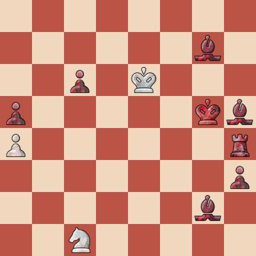

In [ ]:
TEST_IMG

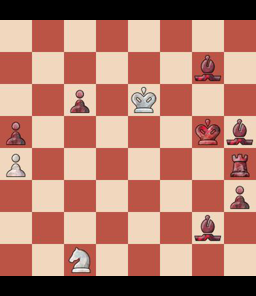

In [ ]:
TEST_IMG = ImageOps.expand(TEST_IMG, (0, 20))
TEST_IMG

In [ ]:
#export
def toPIL(f):
    """ decorator to convert numpy return func to PIL Image"""
    def _f(*args, **kwargs):
        return PIL.Image.fromarray(f(*args, **kwargs))
    return _f

## Convert Color Image to GrayScale

In [ ]:
#export
@toPIL
def color_to_gray(i)->PIL.Image:
    i=np.array(i)
    assert i.ndim==3
    i_gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    assert i_gray.ndim==2
    return i_gray

In [ ]:
i = color_to_gray(TEST_IMG)

In [ ]:
test_eq(np.array(i).ndim, 2)

In [ ]:
test_eq(np.array(i).dtype, np.uint8)

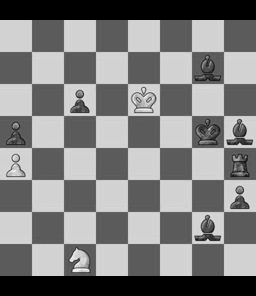

In [ ]:
i

In [ ]:
i.shape

(296, 256)

## Convert Image to black and white

* black and white images have only pure white and pure black
* gray images have any value between 0-255 for uints and 0-1 for floats

In [ ]:
#export
@toPIL
def gray_to_bw(i):
    """ threshold image on mean of offset image and """
    i_gray = np.array(i)
    assert i_gray.ndim == 2
    mean = i_gray[20:-20,20:-20].mean()
    thresh, i_bw = cv2.threshold(i_gray, mean, 255, cv2.THRESH_BINARY)
    assert i_bw.ndim == 2
    return i_bw

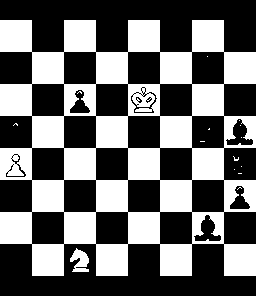

In [ ]:
bw = gray_to_bw(color_to_gray(TEST_IMG))
bw

In [ ]:
#export
def is_bw(i):
    # image is either 255 or 0
    return np.array(i).size - (np.array(i)==255).sum() - (np.array(i)==0).sum() == 0

In [ ]:
test_eq(is_bw(bw), True)

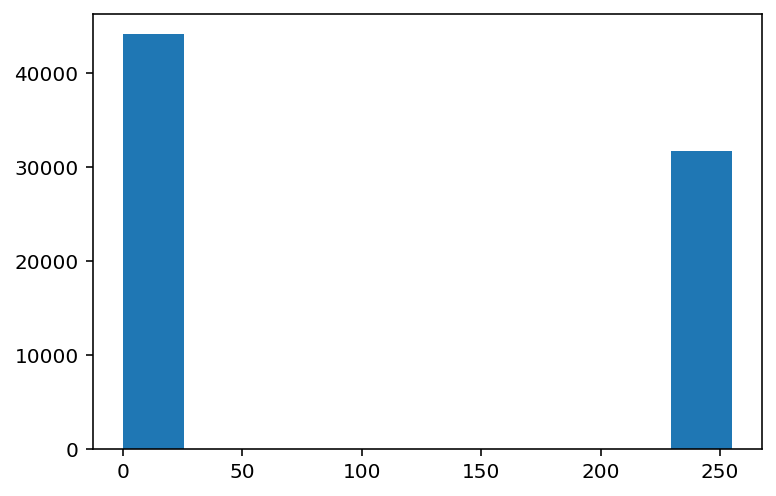

In [ ]:
plt.hist(np.array(bw).ravel()); # histogram should be strictly bimodal

## Create Image with contours

In [ ]:
#export
def contourFilter(contour, min_ratio, img_area):
    _,_,w,h = tmp = cv2.boundingRect(contour)
    if w == 0 or h == 0: return -1
    ratio = min(w,h)/float(max(w,h))
    area = cv2.contourArea(contour)
    return ratio > min_ratio and area > 1/100 * img_area

In [ ]:
#export
def drawContour(image, contour, color=(255, 0, 0), thickness=4):
    for i in range(len(contour)):
        p1 = contour[i]
        p2 = contour[int((i+1) % len(contour))]
        cv2.line(image, p1.ravel(), p2.ravel(), color, thickness)

In [ ]:
#export
@toPIL
def bw_to_contours(i):
    i = np.array(i)
    assert i.ndim==2
    assert is_bw(i)
    
    contoursB, hierarchy = cv2.findContours(i, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    f = partial(contourFilter, min_ratio=0.9, img_area=i.shape[0]*i.shape[1])
    contoursA = list(filter(f, contoursB))

    i_con = np.zeros(i.shape, dtype=np.uint8)
    red = (255, 0, 0)
    for contour in contoursA:
        drawContour(i_con, contour, red, thickness=2)
    
    thresh, i_con = cv2.threshold(i_con, i_con.ravel().mean(), 255, cv2.THRESH_BINARY)

    return i_con

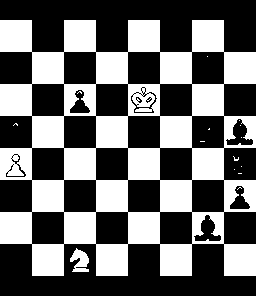

In [ ]:
bw

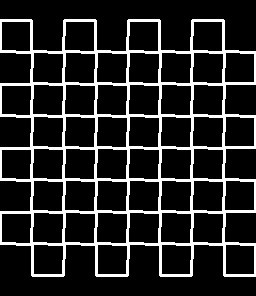

In [ ]:
c = bw_to_contours(bw)
c

In [ ]:
c.shape

(296, 256)

In [ ]:
test_eq(is_bw(c), True)

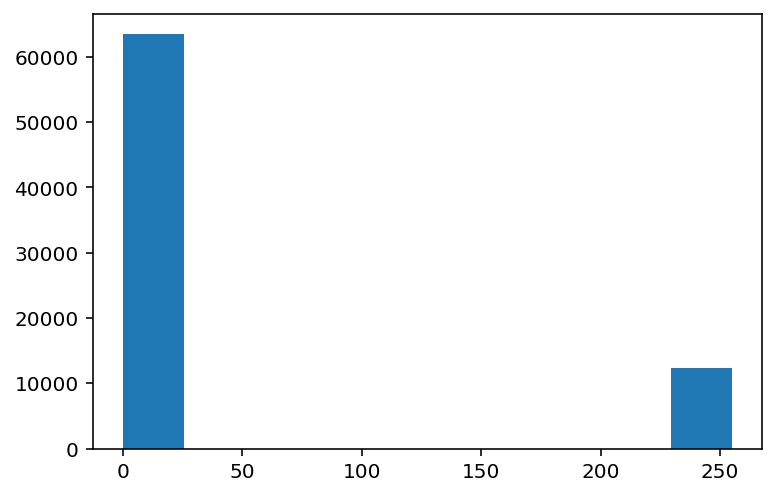

In [ ]:
plt.hist(np.array(c).ravel());

In [ ]:
test_eq(is_bw(c), True)

## Draw Hough Lines

In [ ]:
#export
def draw_hough_lines(img, lines):
    for line in lines:
        rho, theta, accum = list(line)
        if isclose(theta, 0.0):
            x1 = 0
            y1 = y2 = int(rho)
            x2 = 4000
        elif isclose(theta, np.pi/2):
            y1 = 0
            y2 = 4000
            x1 = x2 = int(rho)
        else:
            continue
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 1)
    return img

def draw_hough_linesp(img, lines):
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

In [ ]:
#export
@toPIL
def contour_to_hough(img):
    img = np.array(img)
    lines = cv2.HoughLinesWithAccumulator(image=img, rho=1, theta=np.pi/4, threshold=1)
    if lines is not None:
        lines = lines.squeeze(1)
        h = np.zeros(img.shape, dtype='uint8')
        return draw_hough_lines(h, lines)
    else:
        print("no lines found")

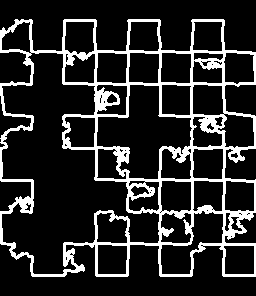

In [ ]:
c

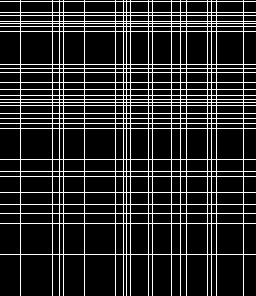

In [ ]:
h = contour_to_hough(c)
h

## Image to Contours

In [ ]:
#export
def color_to_contours(img):
    i = color_to_gray(img)
    b = gray_to_bw(i)
    c = bw_to_contours(b)
    return c

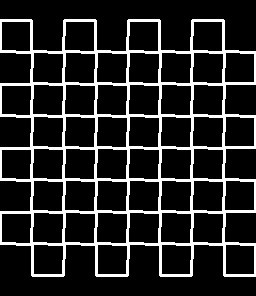

In [ ]:
color_to_contours(TEST_IMG)

## Fourier Transform on Hough Lines

In [ ]:
class Fourier:
    def __get__(self):
        ...
        
    def __set__(self):
        ...
    
    def __set_name__(self):
        ...

In [ ]:
#export
class Lines:
    def __init__(self, img, rho=1, theta=np.pi/4, threshold=1):
        self.lines = cv2.HoughLinesWithAccumulator(image=img, rho=rho, theta=theta, threshold=threshold)
        self.df = pd.DataFrame(self.lines.squeeze(1)[:,1:], index=self.lines.squeeze(1)[:,0], columns=['theta', 'score'])
        self.hsg = self.df[self.df.theta==np.pi/2].reindex(range(0, img.shape[0]), fill_value=0).score
        self.vsg = self.df[self.df.theta==0].reindex(range(0, img.shape[0]), fill_value=0).score
        
    def _period(self, x):
        N=len(x)
        T=1
        yf = fft(x.to_numpy())
        xf=fftfreq(N, T)[:N//2]
        idx = np.argmax(np.abs(yf[1:N//2]))
        return 1/xf[idx]
    
    @property
    def vspace(self):
        return self._period(self.vsg)
        
    @property
    def hspace(self):
        return self._period(self.hsg)

    def show(self):
        fig = plt.figure(figsize=(8, 8))
        gs = fig.add_gridspec(2, 2)
        ax1=fig.add_subplot(gs[0, 0])
        ax1.plot(self.hsg)
        ax1.set_title("horizontal")
        ax1.set_xlim(0, len(self.hsg))
        ax2=fig.add_subplot(gs[0, 1])
        ax2.plot(self.vsg)
        ax2.set_xlim(0, len(self.vsg))
        ax2.set_title("vertical")

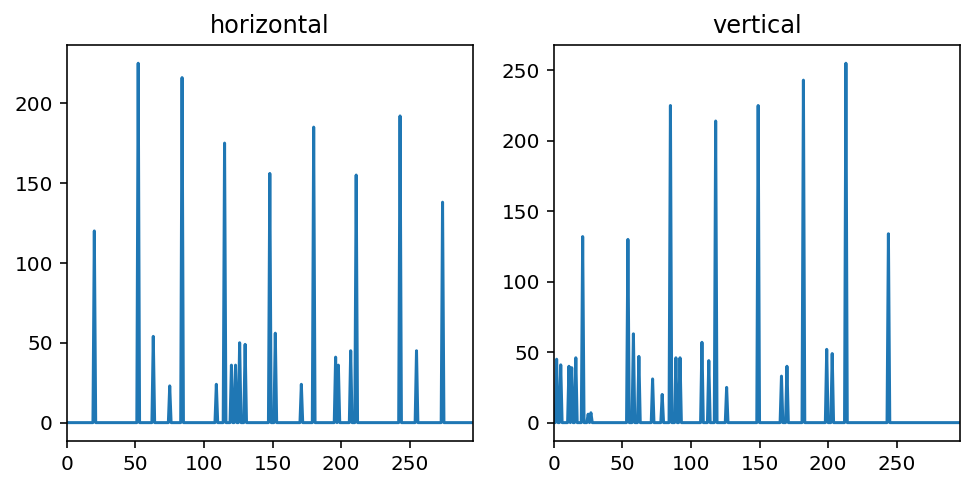

In [ ]:
img = np.array(c)[:,10:]
lines = Lines(img)
lines.show()

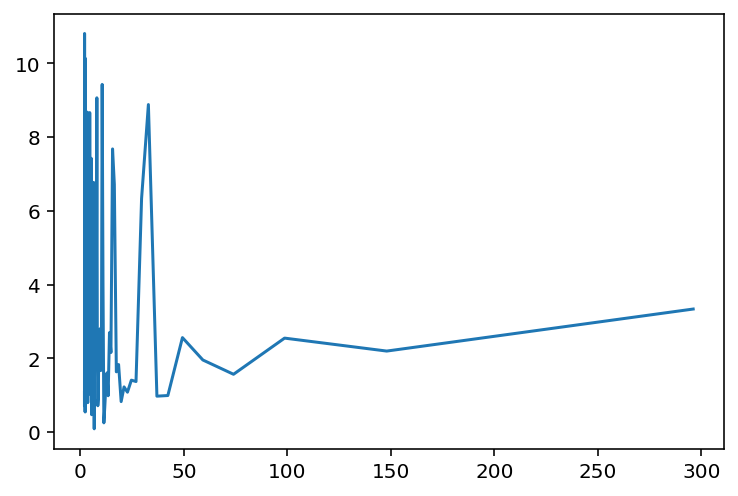

In [ ]:
x = lines.vsg
N=len(x)
T=1
yf = fft(x.to_numpy())
xf=fftfreq(N, T)[:N//2]
plt.plot(1/xf[1:], 2.0/N * np.abs(yf[1:N//2]))

In [ ]:
idx = np.argmax(np.abs(yf[1:N//2]))

In [ ]:
1/xf[idx]

2.084507042253521

In [ ]:
np.angle(yf[idx])

-2.4465132

In [ ]:
img.shape

(296, 246)

In [ ]:
np.angle??

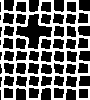

In [ ]:
PIL.Image.fromarray(img)

In [ ]:
1/xf[7]*np.angle(yf[7])+14

8.358410579817637

## DataLoaders

In [ ]:
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), ), 
    get_items=get_image_files,
    item_tfms=[CropPad(500), contours, ],
    n_inp=1)

In [ ]:
dls=block.dataloaders(URL, batch_size=64)

In [ ]:
class BoardFinder:
    def __init__(self, fname=):
        """ init from file """
        border = 50
        self.fname = fname
        self.orig = PIL.ImageOps.expand(PIL.Image.open(self.fname), (50, 50))
        self.i = np.array(self.orig).copy()
        self.i_gray = cv2.cvtColor(self.i, cv2.COLOR_BGR2GRAY)
        mean = self.i_gray[border:-border, border:-border].mean()
        thresh, self.i_bw = cv2.threshold(self.i_gray, mean, 255, cv2.THRESH_BINARY)
        self.drawContours()
        lines = cv2.HoughLines(self.i_con, 3, np.pi/180, 200).squeeze(1)
        self.i_hough = self.i # np.zeros(self.i_bw.shape, dtype=np.uint8)
        self.draw_hough_lines(lines)
                
    def display(self, size=(200, 200)):
        fig = plt.figure(figsize=(15, 8))
        gs = fig.add_gridspec(1, 5)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(self.orig)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(self.i_gray, cmap='gray')
        
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.imshow(self.i_bw, cmap='gray')
        
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.imshow(self.i_con, cmap='gray')
        
        ax5 = fig.add_subplot(gs[0, 4])
        ax5.imshow(self.i_hough, cmap='gray')
        ax5.set_title(f"{len(self.lines)}")

        for ax in [ax1, ax2, ax3, ax4, ax5]:
            ax.set_xticks([])
            ax.set_yticks([])
        
            
    def __call__(self):
        return self.i_hough

    def __repr__(self):
        return f"{self.fname}"

SyntaxError: invalid syntax (<ipython-input-222-f669a2875565>, line 2)